In [1]:
import rasterio
from rasterio.warp import reproject, Resampling
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray 
import regionmask
import pandas as pd
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

/home/ozlem/anaconda3/envs/geocat/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
data_input_modis = '20140911_modis-fapar_fapar_MODIS-Africa-1-1km_1.0.tif'
data_input_modis_resampled='20140911_modis-fapar_fapar_CommonAfrica-0.05D_1.0.tif'
data_input_modis_resampled_mask='20140911_modis-fapar_fapar_CommonAfrica-0.05D_1.0_mask.tif'


In [3]:
# data_input_vgt = '20140911_vgt-fapar_fapar_SPOTV-Africa-1km_V2.0.tif'
# data_input_vgt_resampled='20140911_vgt-fapar_fapar_CommonAfrica-0.05D_V2.0.tif'
# data_input_vgt_resampled_mask='20140911_vgt-fapar_fapar_CommonAfrica-0.05D_V2.0_mask.tif'

In [4]:
file_csv_area_1= pd.read_csv('AFRICA_MASK.csv')

In [5]:
def Spatial_Aggregation(data_input_modis,data_input_modis_resampled):

    zc = [-36, 38, -19, 52]

    fv = -32768.

    dst_crs = {'init': 'EPSG:4326'}
    sr = 1.0 / 2.0

    hb = sr / 2

    south = zc[0]
    north = zc[1]
    west = zc[2]
    east = zc[3]

    dst_lat = np.arange(south, north, sr) + sr / 2
    dst_lon = np.arange(west, east, sr) + sr / 2

    dst_shape = (dst_lat.size, dst_lon.size)

    dst_transform = rasterio.transform.from_bounds(
        west=dst_lon.min() - sr / 2,
        south=dst_lat.min() - sr / 2,
        east=dst_lon.max() + sr / 2,
        north=dst_lat.max() + sr / 2,
        width=dst_shape[1],
        height=dst_shape[0]
    )

    with rasterio.open(data_input_modis) as src:
        data, transform = reproject(source=src.read(),
                                    destination=np.zeros(dst_shape),
                                    src_transform=src.transform,
                                    dst_transform=dst_transform,
                                    src_crs=src.crs,
                                    dst_crs=src.crs,
                                    dst_nodata=fv,
                                    src_nodata=fv,
                                    resampling=Resampling.average)
        data = data.astype('float')
        data[data == fv] = np.nan
        data *= 0.001
    
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': dst_shape[1],
            'height': dst_shape[0]
        })
 
        with rasterio.open(
            data_input_modis_resampled,
            'w',
            driver='GTiff',
            height=dst_shape[0],
            width=dst_shape[1],
            count=1,
            dtype=np.float32,
            crs=dst_crs,
            transform=dst_transform,
        ) as dest_file:
            dest_file.write(data, 1)
            dest_file.close()





In [6]:
data1=Spatial_Aggregation(data_input_modis,data_input_modis_resampled)
data1

In [7]:
raster = xarray.open_dataset(data_input_modis_resampled)
raster

<xarray.Dataset>
Dimensions:      (band: 1, x: 142, y: 148)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -18.75 -18.25 -17.75 -17.25 ... 50.75 51.25 51.75
  * y            (y) float64 37.75 37.25 36.75 36.25 ... -34.75 -35.25 -35.75
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [8]:
print('Modis resampled shape:',raster.rio.shape)
print('Modis resampled resolution:',raster.rio.resolution())
print('Modis resampled bounds:',raster.rio.bounds())

Modis resampled shape: (148, 142)
Modis resampled resolution: (0.5, -0.5)
Modis resampled bounds: (-19.0, -36.0, 52.0, 38.0)


In [9]:
colors = ["lightgoldenrodyellow","palegoldenrod","#c7c230","darkkhaki","forestgreen","#34631a","#184a0e","darkred","#e60707","red"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

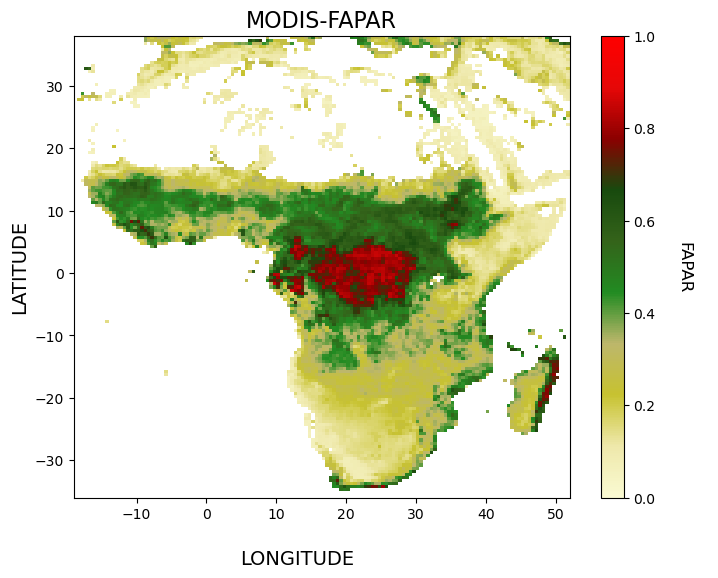

In [15]:

fig, ax = plt.subplots(1, figsize=(8,6), dpi= 100)
plot=raster.band_data.plot(cmap=cmap1,vmin=0,vmax=1,add_colorbar=False)
plt.title('MODIS-FAPAR',fontsize = 16)
ax.set_ylabel('')
ax.set_xlabel('')

plt.xlabel("\nLONGITUDE",x=0.45,size=14)
plt.ylabel("LATITUDE",size=14)

cbar = plt.colorbar(plot,ax=ax)
cbar.set_label('\nFAPAR',labelpad=+38, rotation=270,size=12)

plt.show()

In [11]:
def Mask_Area_Plot(data_input_modis_resampled,data_input_modis_resampled_mask):

    t1 = xarray.open_dataset(data_input_modis_resampled)
   
    k_rename1=t1.band_data.rename({'x': 'lon','y': 'lat'})
    
    ts1 = k_rename1[:,:,:]

    ts1[:]
    ts1_mask= np.mean(ts1[:],axis = 0) 
    
    lon_name_ts1   = ts1.lon[:]
    lat_name_ts1   = ts1.lat[:]

    
    outline_africa = np.array(file_csv_area_1)

    region_area_africa = regionmask.Regions([outline_africa])
    
    mask_pygeos_area_ts1 = region_area_africa.mask(k_rename1, method="pygeos") 
    
    LON, LAT = np.meshgrid(lon_name_ts1, lat_name_ts1)
    
    ts1_area = ts1_mask.values
    ts1_area[np.isnan(mask_pygeos_area_ts1)] = np.nan 
    
    ts1_mask.rio.set_crs("epsg:4326")
    ts1_mask.rio.set_spatial_dims("lon", "lat", inplace=True)
    
    ds = ts1_mask.rio.write_crs("epsg:4326")
    
    ds.rio.to_raster(data_input_modis_resampled_mask)

    #plt.savefig('save.png')

    return Mask_Area_Plot

In [12]:
mask=Mask_Area_Plot(data_input_modis_resampled,data_input_modis_resampled_mask)

/home/ozlem/anaconda3/envs/geocat/lib/python3.10/site-packages/pygeos/io.py:89: UserWarning: The shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the PyGEOS GEOS version (3.10.4-CAPI-1.16.2). Conversions between both will be slow
  warnings.warn(


In [13]:
raster1_mask = xarray.open_dataset(data_input_modis_resampled_mask)


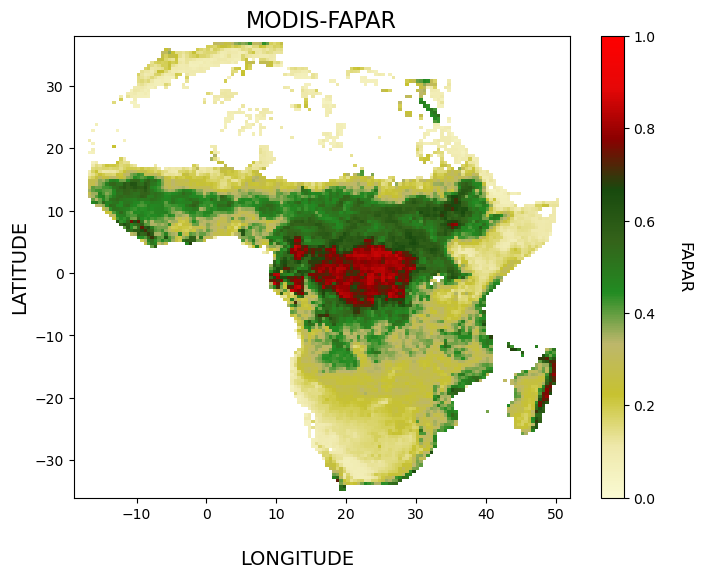

In [14]:
fig, ax = plt.subplots(1, figsize=(8,6), dpi= 100)
plot=raster1_mask.band_data.plot(cmap=cmap1,vmin=0,vmax=1,add_colorbar=False)
plt.title('MODIS-FAPAR',fontsize = 16)
ax.set_ylabel('')
ax.set_xlabel('')

plt.xlabel("\nLONGITUDE",x=0.45,size=14)
plt.ylabel("LATITUDE",size=14)

cbar = plt.colorbar(plot,ax=ax)
cbar.set_label('\nFAPAR',labelpad=+38, rotation=270,size=12)

plt.show()